In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt

In [3]:
def convert_monetary(value):
    if not value or value.strip() == '':
        return np.nan

    if value == '€0':
        return 0

    multiplier = 1
    if 'M' in value:
        multiplier = 1e6
    elif 'B' in value:
        multiplier = 1e9

    numeric_value = float(value[1:-1]) * multiplier

    return numeric_value

In [4]:
def label_result(home_goals, away_goals):
    if home_goals > away_goals:
        return 'Home Win'
    elif home_goals < away_goals:
        return 'Away Win'
    else:
        return 'Draw'

In [5]:
df = pd.read_csv('../data/all_games_stats_with_team_ratings.csv')

In [6]:
df['Result'] = df.apply(lambda row: label_result(row['Home_Goals'], row['Away_Goals']), axis=1)

In [7]:
df.loc[:, ['Season', 'Home_Team_Name', 'Away_Team_Name', 'Home_Goals', 'Away_Goals', 'Result']].head()

,Season,Home_Team_Name,Away_Team_Name,Home_Goals,Away_Goals,Result
0,2015,Aston Villa,Everton,1,3,Away Win
1,2015,AFC Bournemouth,Southampton,2,0,Home Win
2,2015,Leicester City,West Bromwich Albion,2,2,Draw
3,2015,Norwich City,Chelsea,1,2,Away Win
4,2015,Sunderland,Crystal Palace,2,2,Draw


In [8]:
df.drop(['Season', 'Home_Goals', 'Away_Goals', 'Home_shots_on_goal', 'Home_shots_outsidebox', 'Home_shots_off_goal', 'Home_total_shots', 'Home_blocked_shots', 'Home_shots_insidebox', 'Home_corner_kicks', 'Home_ball_possession', 'Home_yellow_cards', 'Home_goalkeeper_saves', 'Home_total_passes', 'Home_passes_accurate', 'Home_passes_%', 'Away_shots_on_goal', 'Away_shots_off_goal', 'Away_total_shots', 'Away_blocked_shots', 'Away_shots_insidebox', 'Away_shots_outsidebox', 'Away_corner_kicks', 'Away_offsides', 'Away_ball_possession', 'Away_yellow_cards', 'Away_goalkeeper_saves', 'Away_total_passes', 'Away_passes_accurate', 'Away_passes_%', 'Home_offsides', 'Away_red_cards', 'Home_red_cards', 'Home_fouls', 'Away_fouls', 'Home_expected_goals', 'Away_expected_goals'], axis=1, inplace=True)

In [9]:
df.columns

Index(['Match_Date', 'Home_Team_Name', 'Away_Team_Name', 'Home_Overall',
       'Home_Attack', 'Home_Midfield', 'Home_Defence', 'Home_Transfer budget',
       'Home_Club worth', 'Home_Speed', 'Home_Dribbling', 'Home_Passing',
       'Home_Positioning', 'Home_Crossing', 'Home_Shooting', 'Home_Aggression',
       'Home_Pressure', 'Home_Team width', 'Home_Defender line',
       'Home_Domestic prestige', 'Home_International prestige', 'Home_Players',
       'Home_Starting XI average age', 'Home_Whole team average age',
       'Away_Overall', 'Away_Attack', 'Away_Midfield', 'Away_Defence',
       'Away_Transfer budget', 'Away_Club worth', 'Away_Speed',
       'Away_Dribbling', 'Away_Passing', 'Away_Positioning', 'Away_Crossing',
       'Away_Shooting', 'Away_Aggression', 'Away_Pressure', 'Away_Team width',
       'Away_Defender line', 'Away_Domestic prestige',
       'Away_International prestige', 'Away_Players',
       'Away_Starting XI average age', 'Away_Whole team average age',
       '

In [10]:
df['Month'] = df['Match_Date'].astype(str).str[1:3]

df.drop(['Match_Date'], axis=1, inplace=True)

In [11]:
df['Home_Transfer budget'].unique()

df['Home_Club worth'].unique()

array(['€0', '€45M', '€525.6M', '€900M', '€780M', '€2.4B', '€2B', '€400M',
       '€2.2B', '€800M', '€560M', '€1.3B', '€650M', '€406.6M', '€3.6B',
       '€1.9B', '€1.8B', '€555.6M', '€14M', '€26M', '€1.4B', '€435M',
       '€2.5B', '€660M', '€1.1B', '€3B', '€525M', '€390M', '€615M',
       '€120M', '€540M', '€2.3B', '€635M', '€80M', '€440M', '€575M',
       '€2.8B', '€983M', '€90M', '€981.5M', '€640M', '€979M', '€3.5B',
       '€425M', '€15M', '€50M', '€551.3M', '€3.4B', '€383.3M', '€418.5M',
       '€401.6M', '€462M', '€1.7B', '€200M', '€332.5M', '€388.5M',
       '€2.7B', '€180M', '€378.5M', '€2.1B', '€441M', '€430.5M',
       '€682.5M', '€415M', '€533.3M', '€568.5M', '€455.5M', '€100M',
       '€3.3B', '€505M', '€552.5M', '€336M', '€65M', '€110M', '€410.5M',
       '€562.5M', '€565M', '€185.5M', '€411.5M', '€572.5M', '€420.5M',
       '€416.5M', '€107.5M', '€172.5M', '€220.5M', '€178.5M', '€2.9B',
       '€4.6B', '€169.5M', '€228.5M', '€741.5M', '€684.5M', '€730.5M',
       '€2.6B'

In [12]:
df['Home_Transfer budget'] = df['Home_Transfer budget'].apply(convert_monetary)
df['Home_Club worth'] = df['Home_Club worth'].apply(convert_monetary)

In [13]:
df.head()

,Home_Team_Name,Away_Team_Name,Home_Overall,Home_Attack,Home_Midfield,Home_Defence,Home_Transfer budget,Home_Club worth,Home_Speed,Home_Dribbling,...,Away_Pressure,Away_Team width,Away_Defender line,Away_Domestic prestige,Away_International prestige,Away_Players,Away_Starting XI average age,Away_Whole team average age,Result,Month
0,Aston Villa,Everton,75,72,74,74,11500000.0,0.0,Balanced,Normal,...,Medium,Normal,Cover,14,16,33,26.36,24.97,Away Win,03
1,AFC Bournemouth,Southampton,69,69,69,68,3000000.0,0.0,Balanced,Normal,...,Medium,Normal,Cover,11,13,33,26.18,22.82,Home Win,03
2,Leicester City,West Bromwich Albion,72,71,72,68,9500000.0,0.0,Balanced,Normal,...,Medium,Normal,Cover,11,14,33,27.91,24.36,Draw,03
3,Norwich City,Chelsea,72,73,72,71,6500000.0,0.0,Balanced,Normal,...,Medium,Normal,Cover,20,20,33,25.82,22.48,Away Win,03
4,Sunderland,Crystal Palace,74,76,73,72,16000000.0,0.0,Balanced,Normal,...,Medium,Normal,Cover,10,11,33,27.36,25.45,Draw,03


In [14]:
df_encoded = pd.get_dummies(df, columns=['Home_Team_Name', 'Away_Team_Name', 'Home_Speed', 'Home_Dribbling', 'Home_Passing', 'Home_Positioning', 'Home_Crossing', 'Home_Shooting', 'Home_Aggression', 'Home_Pressure', 'Home_Team width', 'Home_Defender line', 'Away_Transfer budget', 'Away_Club worth', 'Away_Speed', 'Away_Dribbling', 'Away_Passing', 'Away_Positioning', 'Away_Crossing', 'Away_Shooting', 'Away_Aggression', 'Away_Pressure', 'Away_Team width', 'Away_Defender line', 'Month'])

In [15]:
X = df_encoded.drop(['Result'], axis=1)
y_labels = df_encoded['Result']

In [16]:
class_mapping = {'Away Win': 0, 'Draw': 1, 'Home Win': 2}
y = y_labels.map(class_mapping)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.45674740484429066


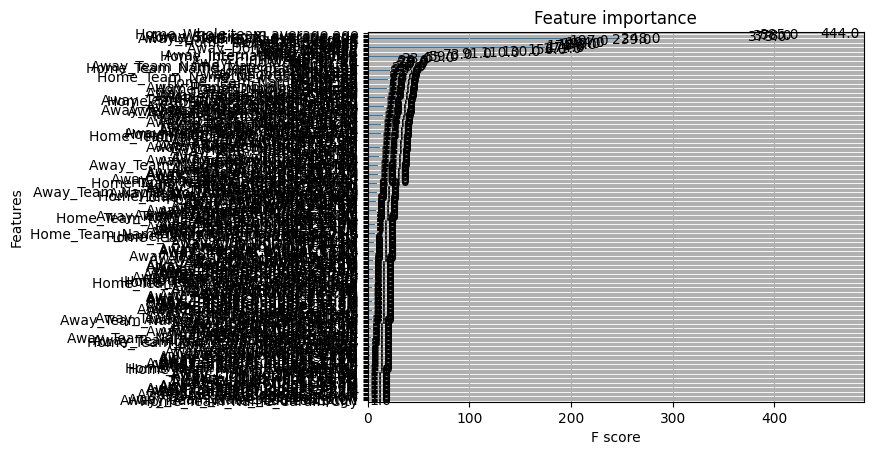

In [20]:
xgb.plot_importance(model)
plt.show()